# Import libraries and data
First load libraries we need for our work. We need multiple libraries to be able to unzip files, work with directories, sklearn, tensorflow...

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import os
import cv2

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline

# Exploratory data analysis
Not too much to look there, but just quickly look on train images and their cleaned version. This is what we put into model to learn how to clean noise from background.

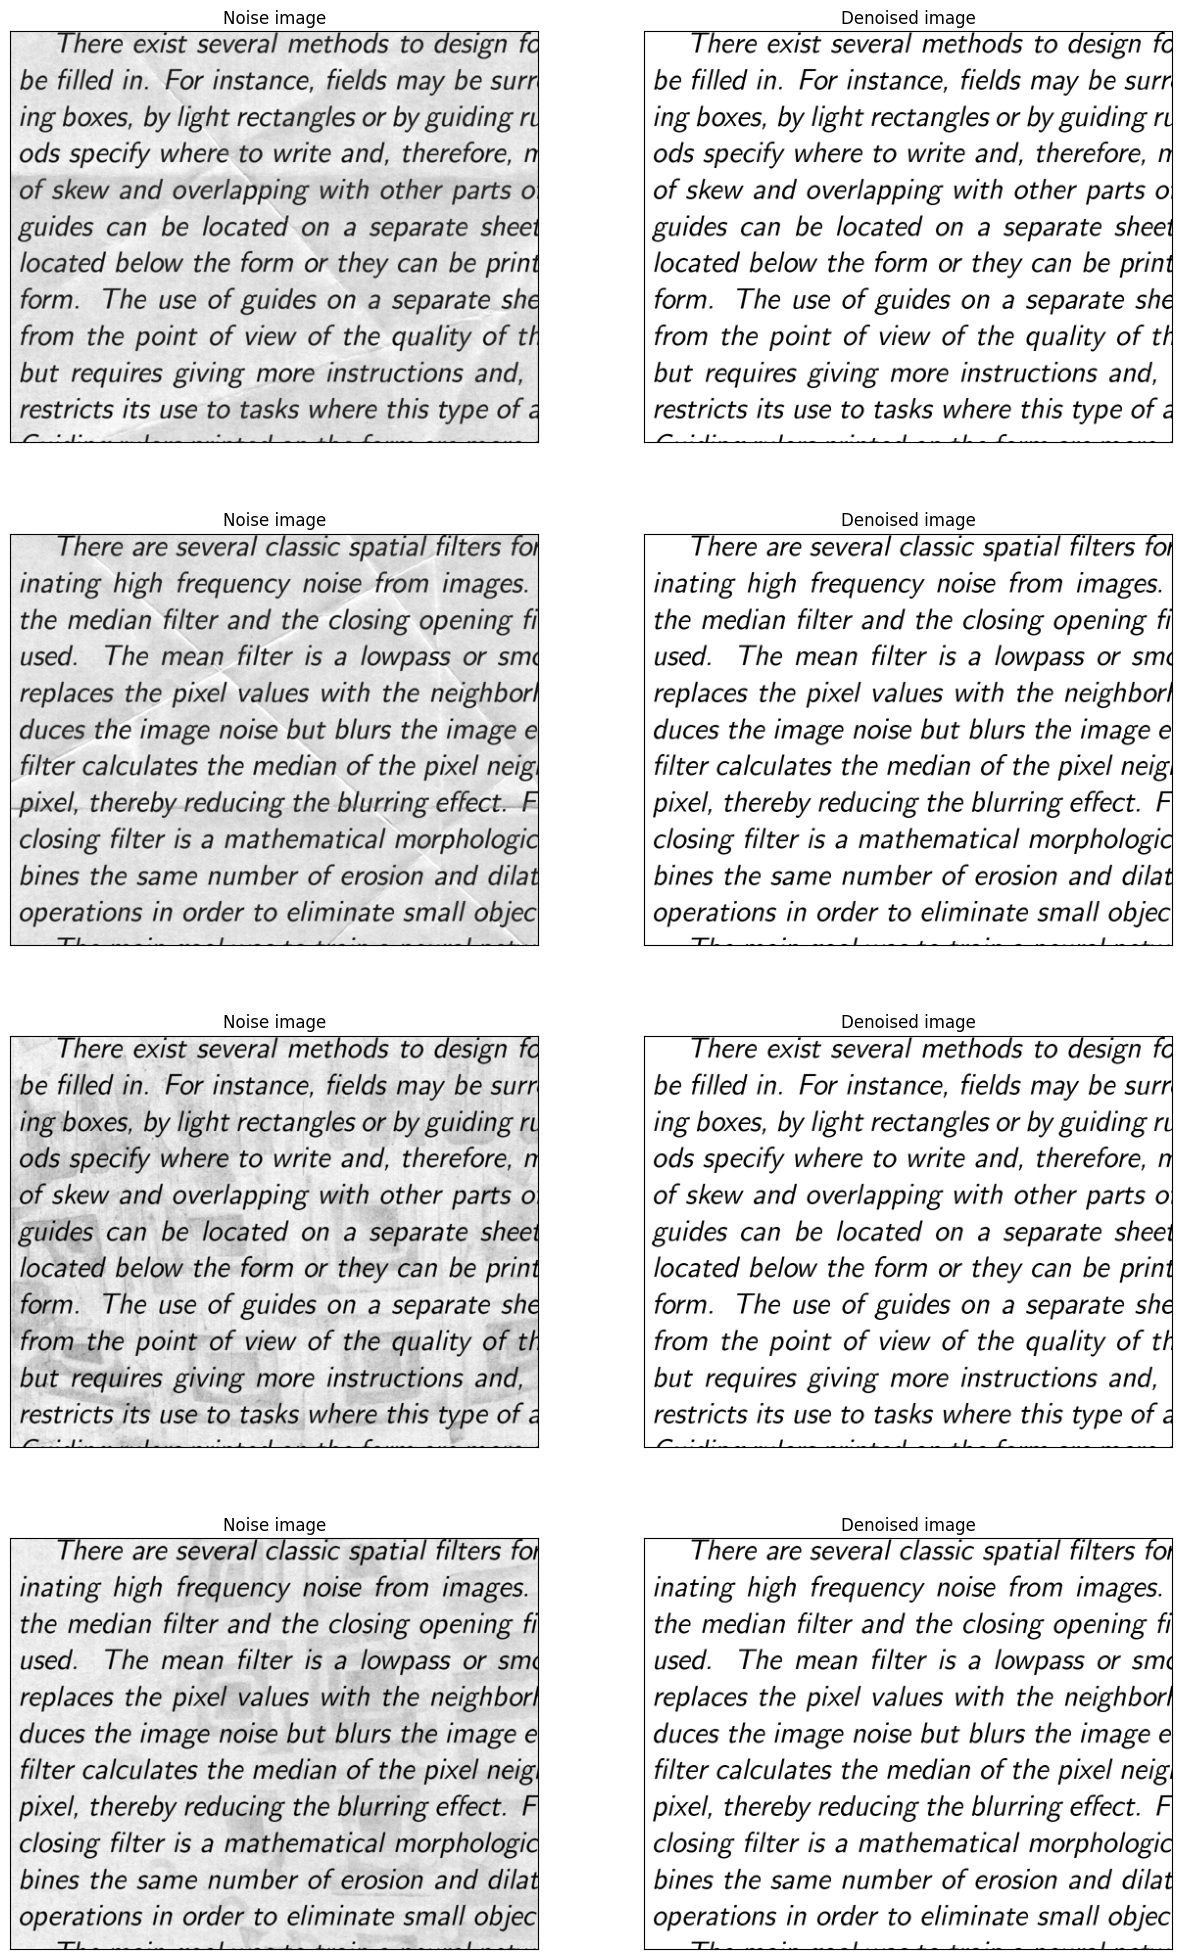

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define the base path to your datasets
path = 'data/'  # Adjust this path to where your datasets are located

# Function to process images
def process_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (540, 420))
    img = img.astype("float32") / 255.0
    img = np.reshape(img, (420, 540, 1))
    return img

# Load and preprocess images
train, train_cleaned, test = [], [], []

for f in sorted(os.listdir(path + 'train/')):
    train.append(process_image(path + 'train/' + f))

for f in sorted(os.listdir(path + 'train_cleaned/')):
    train_cleaned.append(process_image(path + 'train_cleaned/' + f))

for f in sorted(os.listdir(path + 'test/')):
    test.append(process_image(path + 'test/' + f))

# Visualization
plt.figure(figsize=(15, 25))
for i in range(4):  # Adjusted loop to avoid errors and for clarity
    plt.subplot(4, 2, 2*i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train[i][:, :, 0], cmap='gray')
    plt.title('Noise image')

    plt.subplot(4, 2, 2*i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_cleaned[i][:, :, 0], cmap='gray')
    plt.title('Denoised image')

plt.show()


# Split data
In this step we convert lists to numpy arrays and split dataset into train and validation in ration 85% train, 15% test.

In [4]:
# convert list to numpy array
X_train = np.asarray(train)
Y_train = np.asarray(train_cleaned)
X_test = np.asarray(test)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15)

# Modeling


In [5]:
def model():
    input_layer = Input(shape=(420, 540, 1))  # we might define (None,None,1) here, but in model summary dims would not be visible
    
    # encoding
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Dropout(0.5)(x)

    # decoding
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D((2, 2))(x)

    output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    model = Model(inputs=[input_layer], outputs=[output_layer])
    model.compile(optimizer='adam' , loss='mean_squared_error', metrics=['mae'])

    return model


model = model()
model.summary()




Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 420, 540, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 420, 540, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 420, 540, 128)     73856     
                                                                 
 batch_normalization (Batch  (None, 420, 540, 128)     512       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 210, 270, 128)     0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 210, 270, 128)     0  

## Train model
Verbose is going to be set to 0 to avoid filling output with hundreds of lines from training. We will run 300 epochs having early stopping set to 20 (if val loss does not drop in 20 epochs, it will stop).

Let's store history of model as well, so we can plot loss (rmse) and mae.

In [6]:
callback = EarlyStopping(monitor='loss', patience=30)
# Reduce the batch size to decrease memory usage
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=70, batch_size=8, verbose=0, callbacks=[callback])


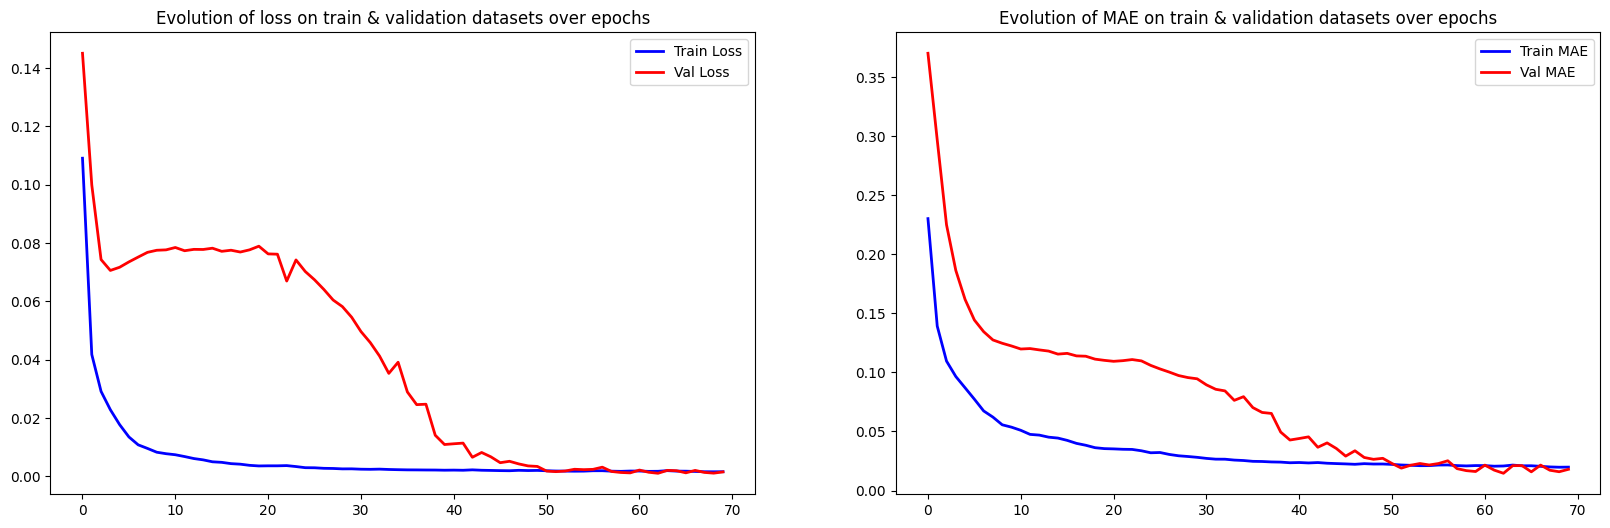

In [7]:
# Check how loss & mae went down
epoch_loss = history.history['loss']
epoch_val_loss = history.history['val_loss']
epoch_mae = history.history['mae']
epoch_val_mae = history.history['val_mae']

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mae)), epoch_mae, 'b-', linewidth=2, label='Train MAE')
plt.plot(range(0,len(epoch_val_mae)), epoch_val_mae, 'r-', linewidth=2,label='Val MAE')
plt.title('Evolution of MAE on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()


# Evaluation
In this step we will "predict", or better say clean test images and check how well model works.

In [8]:
# predict/clean test images
Y_test = model.predict(X_test, batch_size=16)

5/5 [==============================] - 16s 3s/step


In [ ]:
# Evaluate the model on the validation data
loss, accuracy = model.evaluate(X_val, Y_val, verbose=0)

print(f"Validation Mean Absolute Error: {accuracy}")

Now compare noisy (left) and denoised test images (right). Our model has done great job with denoising!

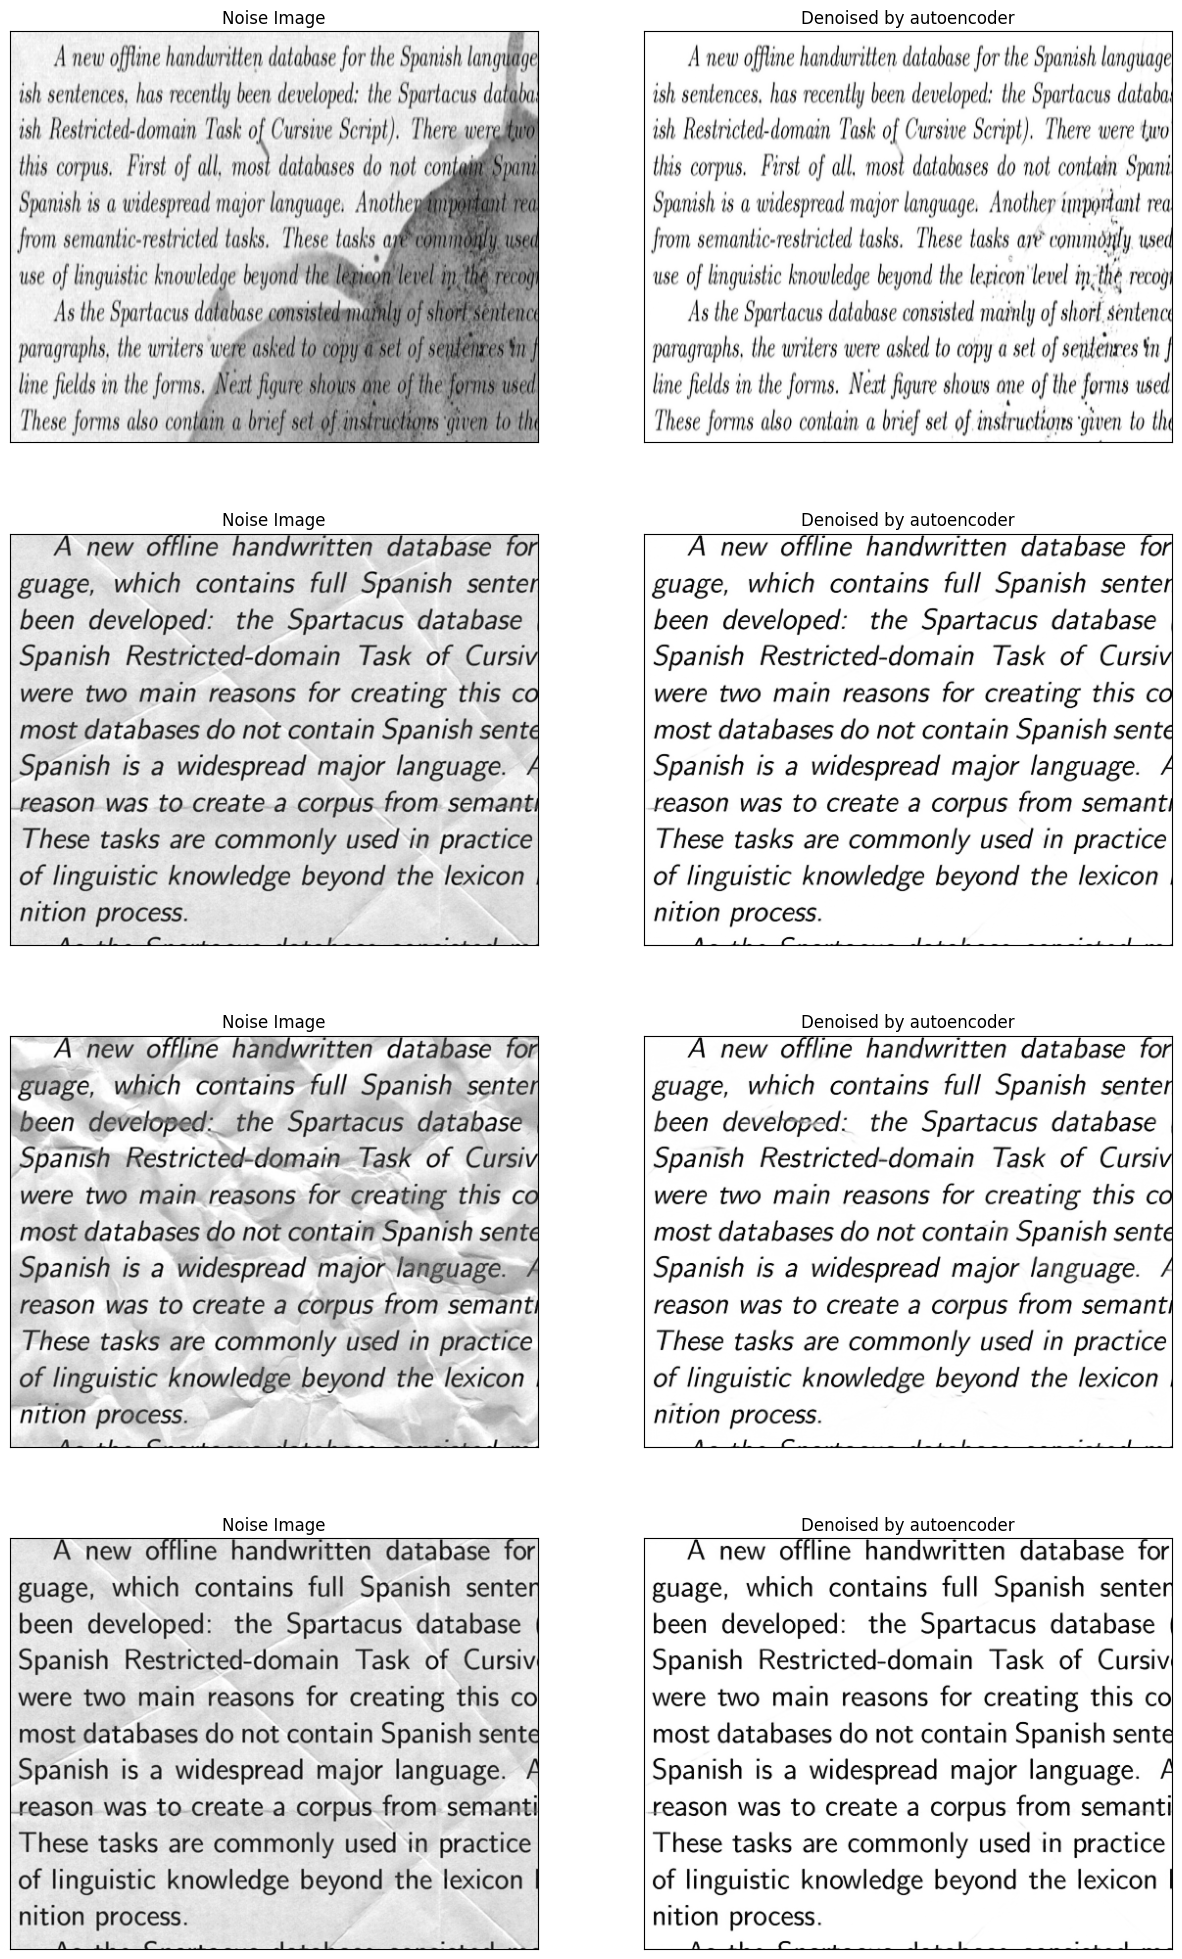

In [ ]:
plt.figure(figsize=(15,25))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[i][:,:,0], cmap='gray')
    plt.title("Noise Image")
    #plt.title('Noisy image: {}'.format(test[i]))
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(Y_test[i][:,:,0], cmap='gray')
    plt.title("Denoised by autoencoder")
    #plt.title('Denoised by autoencoder: {}'.format(test[i]))

plt.show()

In [ ]:
model.save("model_1.h5")

C:\Users\0871\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(





1/1 [==============================] - 1s 609ms/step


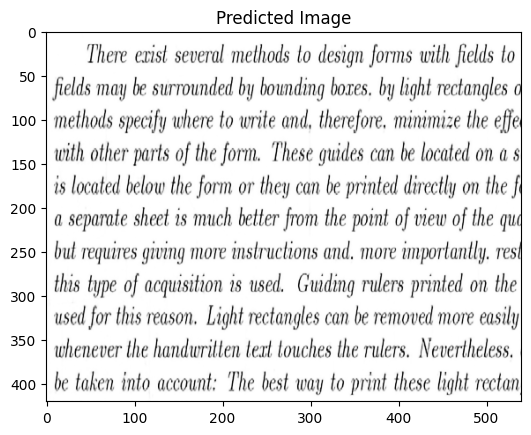

In [1]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from skimage.transform import resize
import matplotlib.pyplot as plt

def predict_single_image(image_path, model_path="model.h5"):
    # Load the model
    model = load_model(model_path)
    
    # Load and preprocess the image
    # Assuming the input images are grayscale, and the model expects (420, 540, 1)
    # Adjust the target_size accordingly if different
    image = load_img(image_path, color_mode='grayscale', target_size=(420, 540))
    image = img_to_array(image) / 255.0  # Normalize to [0, 1]
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    
    # Predict
    prediction = model.predict(image)
    
    predicted_image = prediction.squeeze()  # Remove batch dimension
    plt.imshow(predicted_image, cmap='gray')
    plt.title("Predicted Image")
    plt.show()
predict_single_image(r"data\train\8.png")
